### Sales Prediction Using LSTM

#### Import Modlues

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
sys.path.append('../scripts')

# from read_write_util import ReadWriteUtil
from cleaning_pipeline import CleaningPipeline
from plot_util import *

2022-09-09 12:28:04.695153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 12:28:04.873926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 12:28:04.873962: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-09 12:28:04.903287: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-09 12:28:05.601505: W tensorflow/stream_executor/platform/de

#### Load Data

In [2]:
df_train = pd.read_csv('../data/train_processed.csv')
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayOfMonth,WeekOfYear,weekday
0,1,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,1
1,1,3,2013-01-02,5530,668,1,0,0,1,2013,1,2,1,1
2,1,4,2013-01-03,4327,578,1,0,0,1,2013,1,3,1,1
3,1,5,2013-01-04,4486,619,1,0,0,1,2013,1,4,1,1
4,1,6,2013-01-05,4997,635,1,0,0,1,2013,1,5,1,0


In [3]:
df_train = df_train[['Date','Sales']]
df_train = df_train.groupby('Date').agg({'Sales':'mean'})

#### Scaling Data

In [4]:
data_cleaner = CleaningPipeline()
scaled_cols = data_cleaner.scale_columns(df_train, ['Sales'], range_tup=(-1,1))
scaled_data = data_cleaner.change_datatypes(scaled_cols)

2022-09-09 12:28:08,391:logger:['Sales'] scaled between (-1, 1)
2022-09-09 12:28:08,393:logger:Data types converted.


#### Visualizations

In [5]:
df = df_train

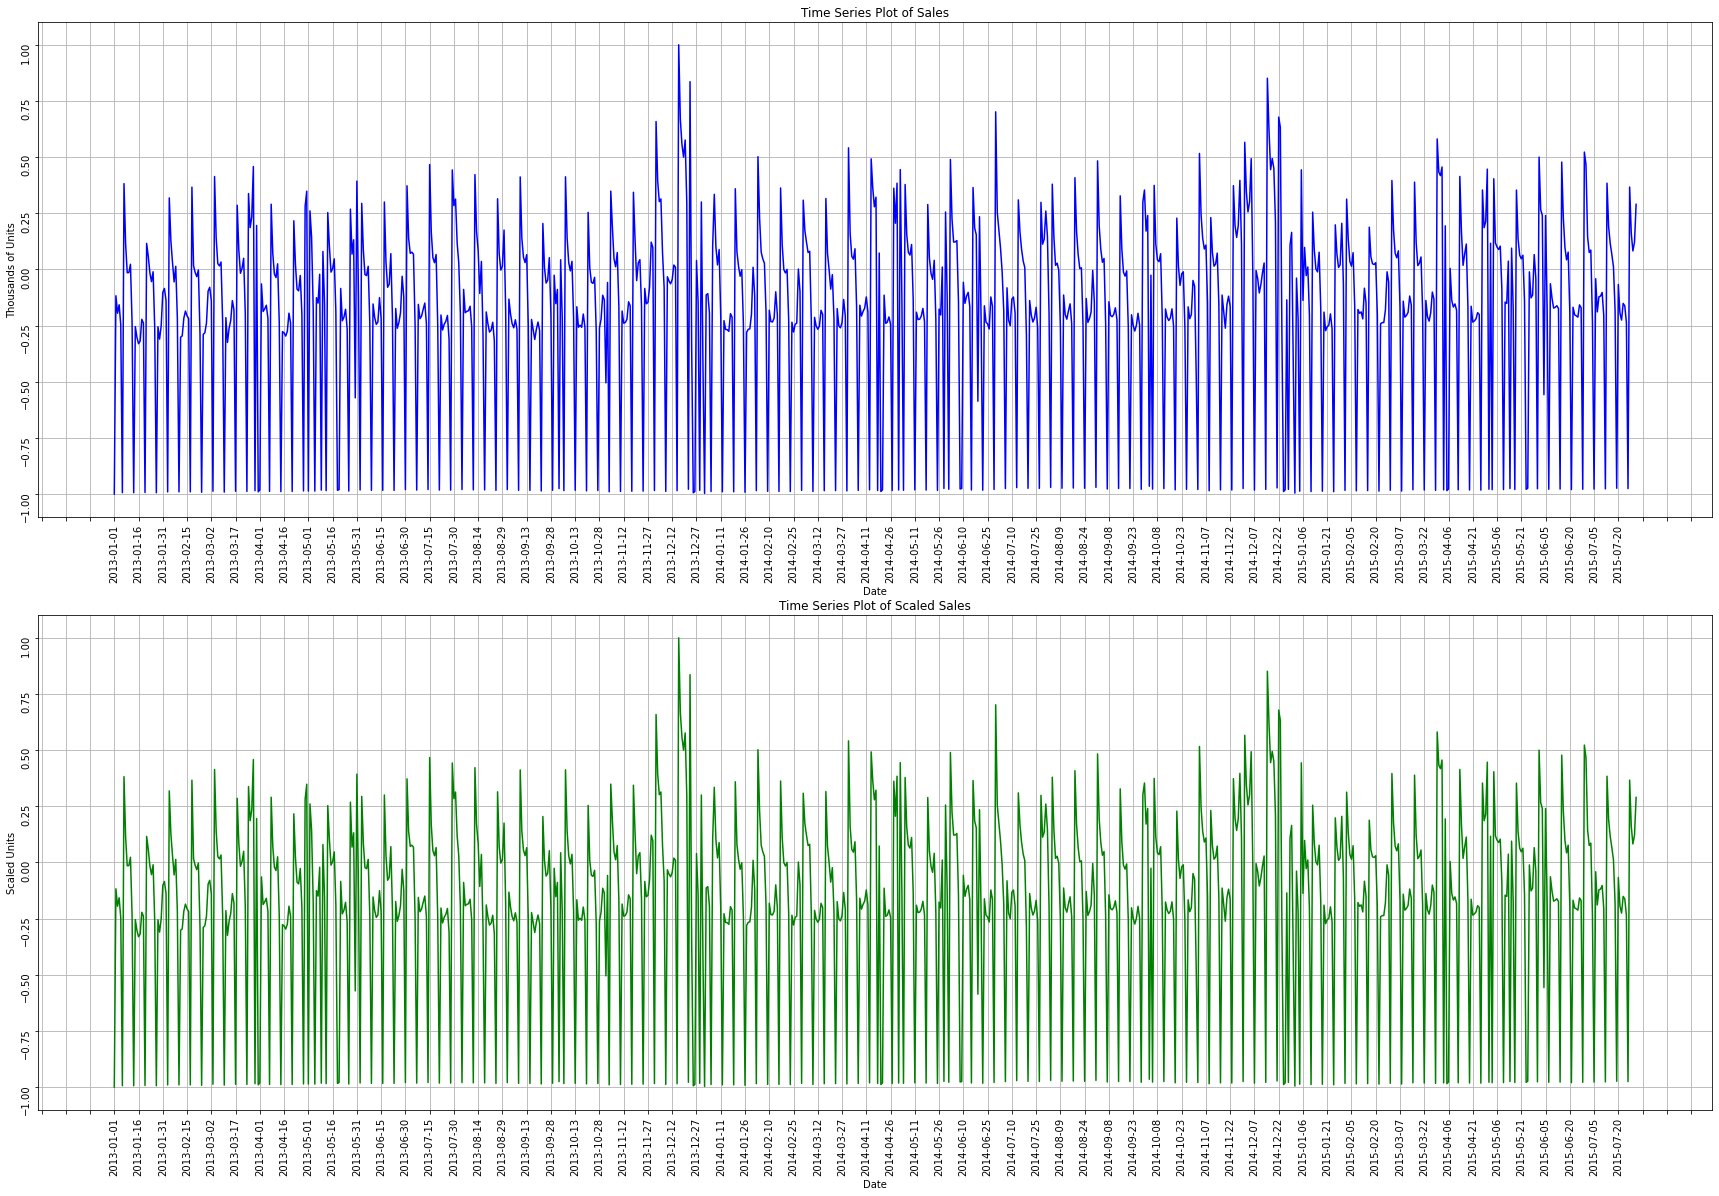

In [6]:
plot_time_series(df,scaled_data)

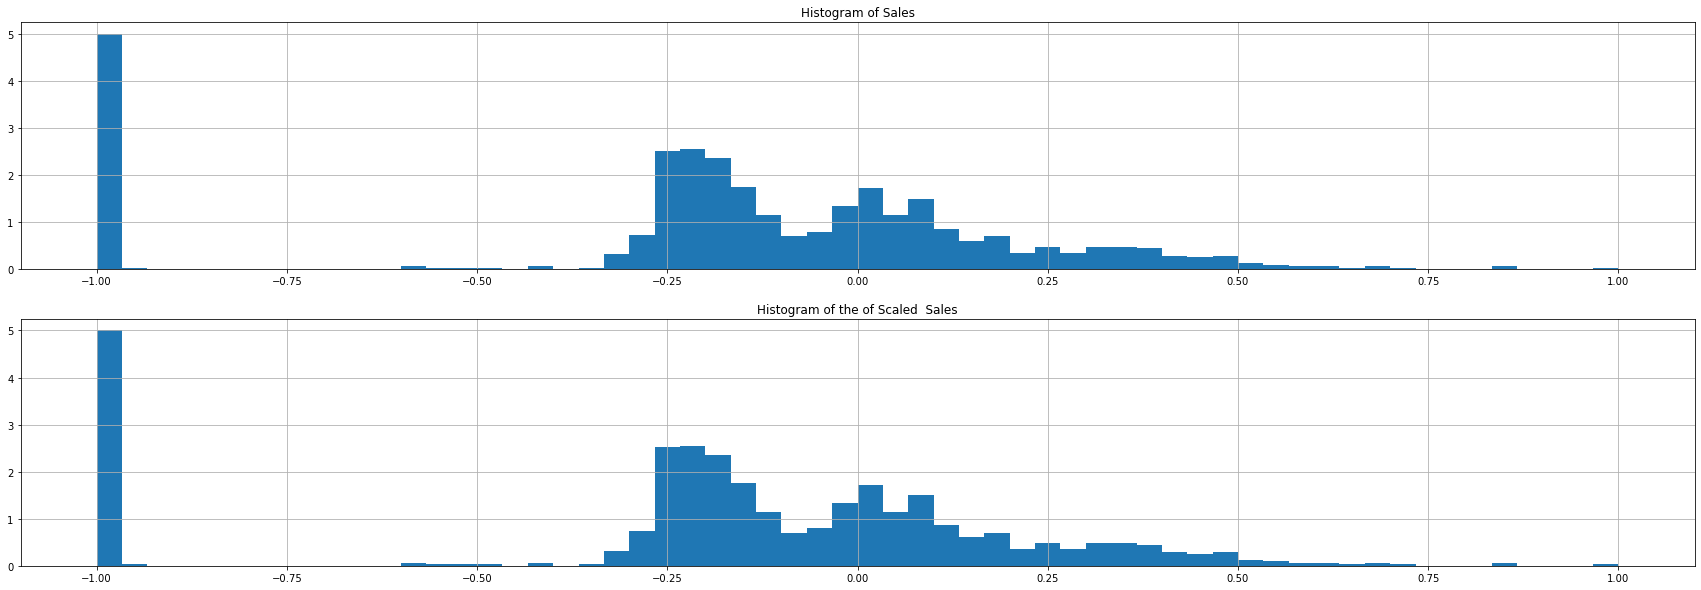

In [8]:
plot_histogram(df,scaled_data)

#### Checking and Removing Stationary

In [9]:
sales_diff = data_cleaner.get_difference(scaled_data.Sales.values)

2022-09-09 12:31:25,868:logger:941 fetched


#### Correlation Plots

In [10]:
acf_scaled = acf(scaled_data.Sales.values, fft=True, nlags=45)
acf_scaled_np = np.array(acf_scaled)

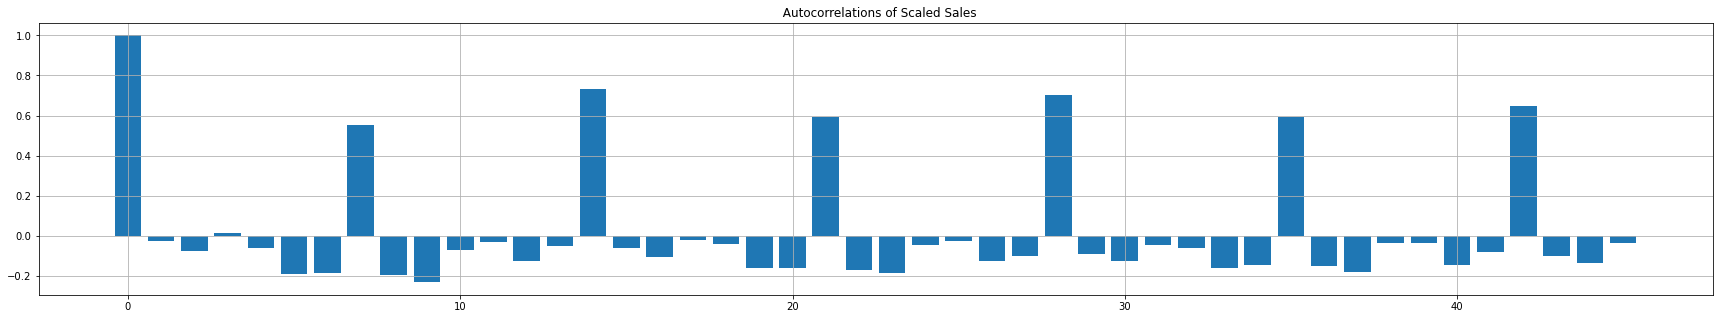

In [11]:
plot_correlations(acf_scaled_np, '')

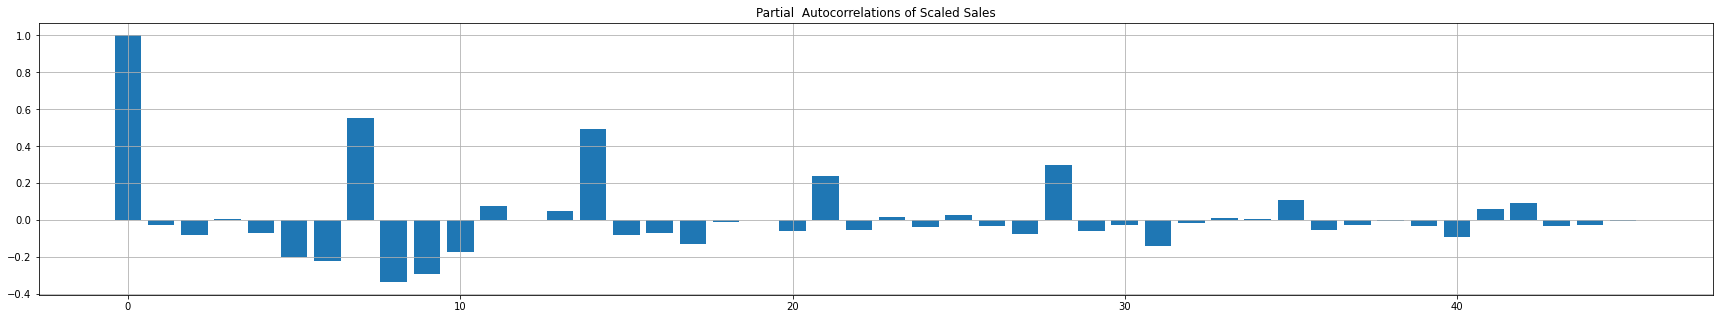

In [13]:
pacf_scaled= pacf(scaled_data.Sales.values, nlags=45)
pacf_scaled_np = np.array(pacf_scaled)
plot_correlations(pacf_scaled_np, "Partial")

#### Set Fomat to Use Feed into LSTM.

In [14]:
SIZE = len(scaled_data.Sales)
WINDOW_SIZE = 45 
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 10
# Set window of past points for LSTM Model
# number of weeks to days

#### Training and Validation Separation 

In [15]:
DateTrain = scaled_data.index.values[0:BATCH_SIZE]
DateValid = scaled_data.index.values[BATCH_SIZE:]
XTrain = scaled_data.Sales.values[0:BATCH_SIZE].astype('float32')
XValid = scaled_data.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (852, 1)
Shape of the validation set date series:  (90, 1)

Shape of the training set logarithm of sales series:  (852,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [17]:
tf.random.set_seed(0)
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([852, 1])

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset
#we create tensor from each individual element

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [19]:
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)
# takes a window_size + 1 chunk from the slices

In [20]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

#### Defining and Estimating LTSM

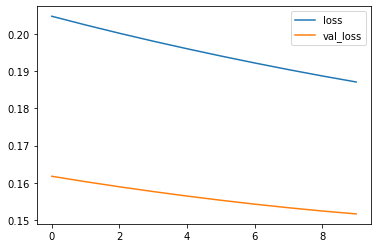

In [21]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [23]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(scaled_data.Sales)/5.0)
Xtrain = scaled_data.Sales[:-last]
Xtest = scaled_data.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [24]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [26]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

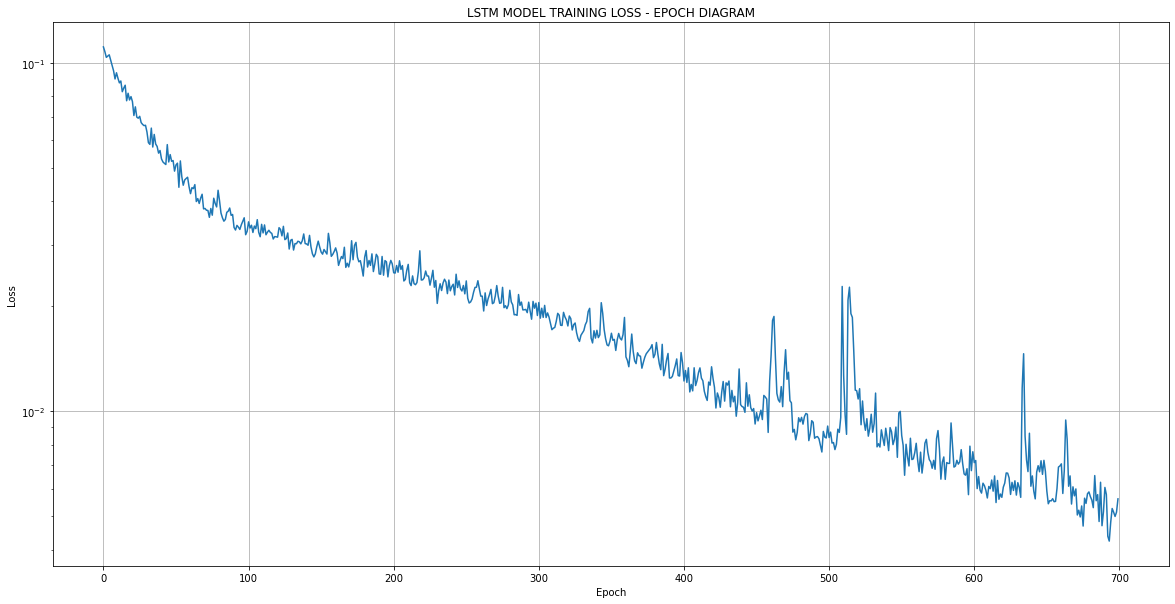

In [27]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [28]:
history.history['loss'][-1]
# Loss value

0.005607960280030966

In [29]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

6/6 [==============================] - 2s 10ms/step


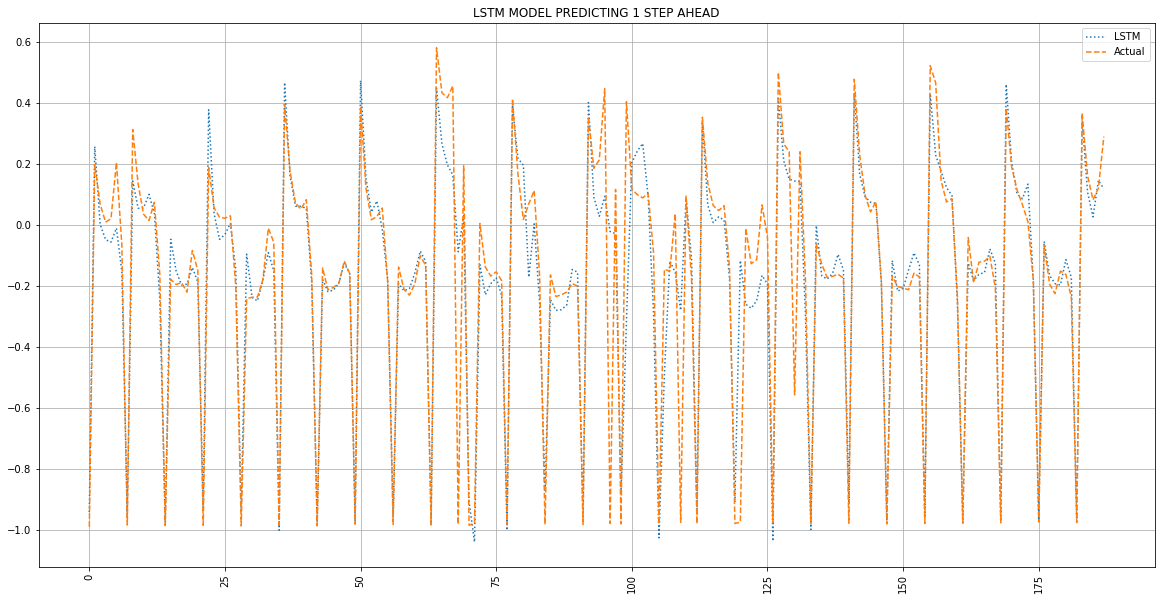

In [30]:
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()
# Plot prediction vs actual for test data


In [31]:
X_pred = Xtest.copy()
for i in range(window, len(X_pred)):
    xin = X_pred[i-window:i].to_numpy().reshape((1, window, 1))
    X_pred[i] = m.predict(xin)
# Using predicted values to predict next step

1/1 [==============================] - 0s 22ms/step


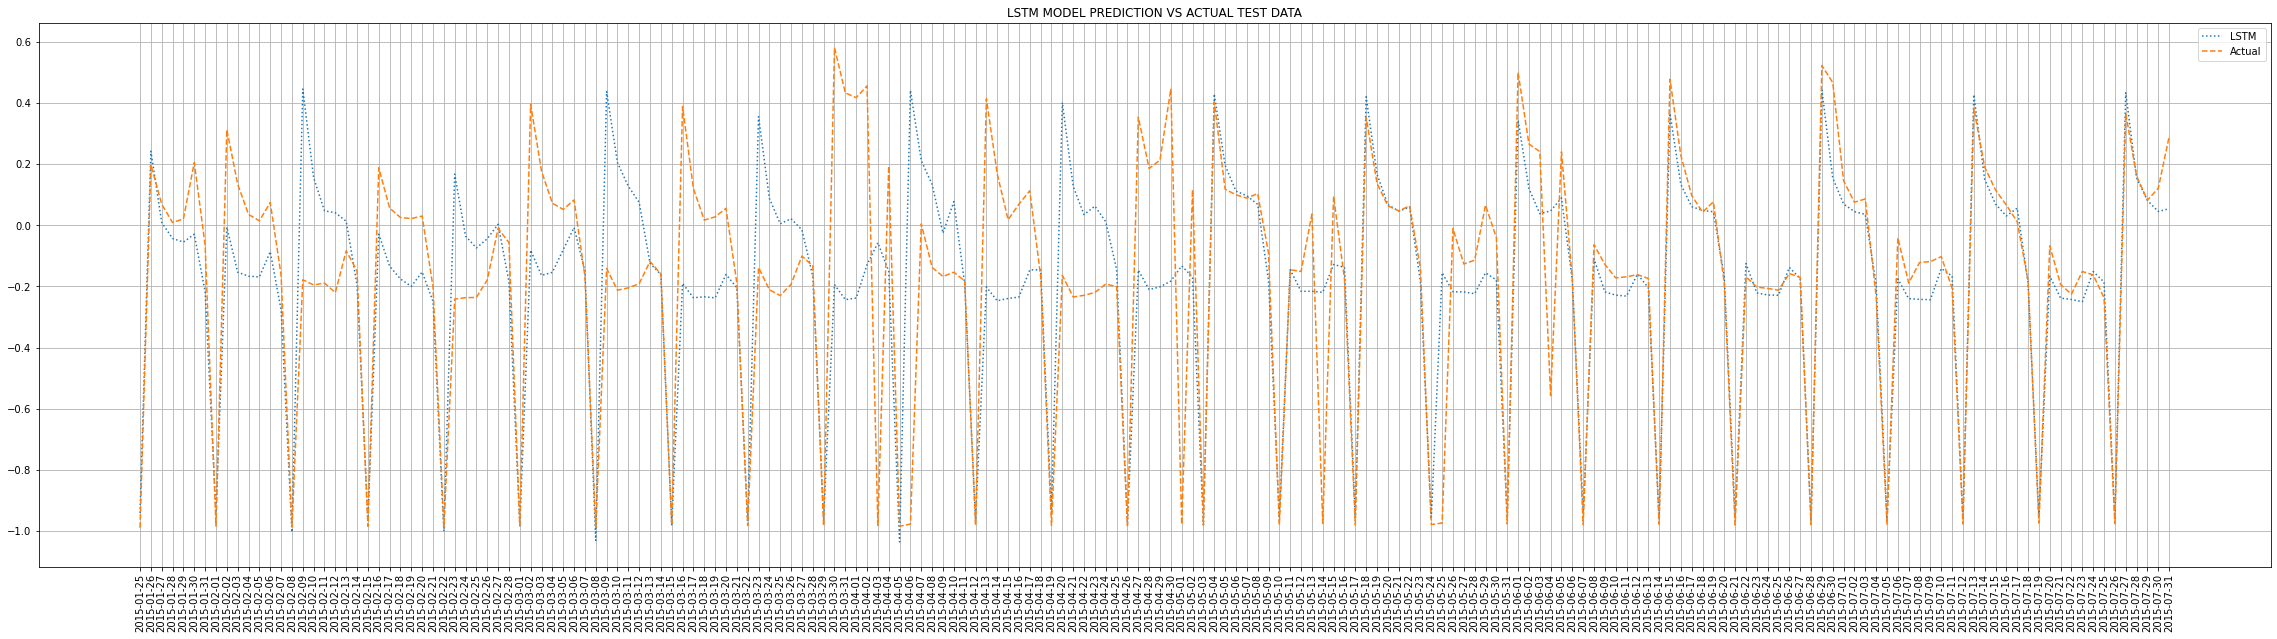

In [32]:
plt.figure(figsize=(40,10))
plt.title('LSTM MODEL PREDICTION VS ACTUAL TEST DATA')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred[window:], ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()
# Plot prediction vs actual for test data

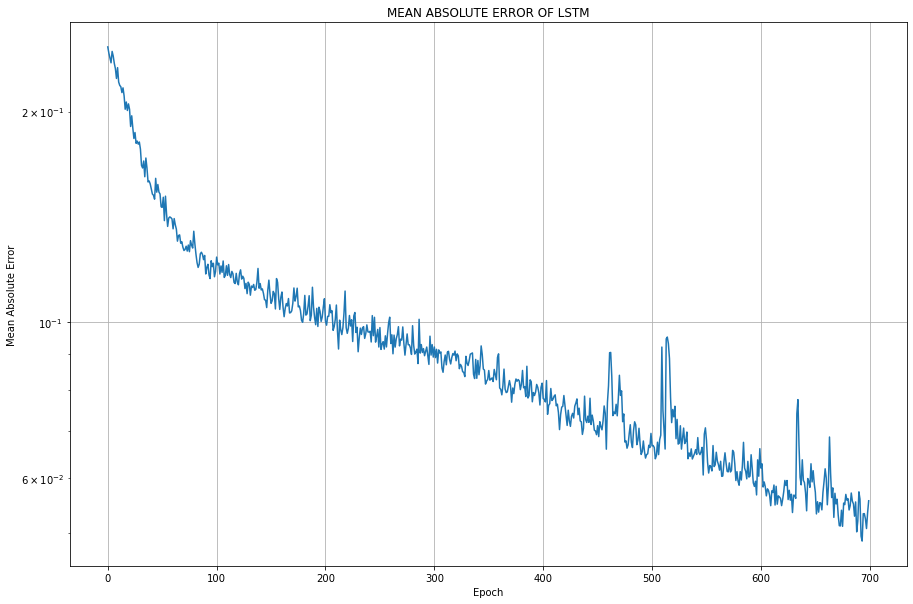

In [33]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])

In [34]:
history.history['mse'][-1]
# Last Mean Squared Error Value

0.005607960280030966

In [35]:
history.history['mae'][-1]
# Last Mean Absolute Error Value

0.05563876032829285

#### Save the Model

In [36]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H:%M:%S", gmtime())
model.save(f'../models/LSTM_sales {time}.pkl')

INFO:tensorflow:Assets written to: ../models/LSTM_sales 2022-09-09-17:05:36.pkl/assets


INFO:tensorflow:Assets written to: ../models/LSTM_sales 2022-09-09-17:05:36.pkl/assets
